In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


import warnings
warnings.filterwarnings('ignore')

In [ ]:
end = '2020-12-31'
start = '1999-01-02'

trainingData = yf.download('^N225', start=start, end=end)
trainingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,13779.049805,13779.049805,13415.889648,13415.889648,13415.889648,0
1999-01-05,13437.030273,13437.030273,13122.610352,13232.740234,13232.740234,0
1999-01-06,13281.690430,13475.629883,13216.179688,13468.459961,13468.459961,0
1999-01-07,13576.000000,13854.160156,13516.410156,13536.559570,13536.559570,0
1999-01-08,13507.059570,13507.059570,13328.339844,13391.809570,13391.809570,0


In [ ]:
end = '2024-03-28'
start = '2021-01-02'

testingData = yf.download('^N225', start=start, end=end)
testingData


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,27575.570312,27602.109375,27042.320312,27258.380859,27258.380859,51500000
2021-01-05,27151.380859,27279.779297,27073.460938,27158.630859,27158.630859,55000000
2021-01-06,27102.849609,27196.400391,27002.179688,27055.939453,27055.939453,72700000
2021-01-07,27340.460938,27624.730469,27340.460938,27490.130859,27490.130859,98900000
2021-01-08,27720.140625,28139.029297,27667.750000,28139.029297,28139.029297,84900000
...,...,...,...,...,...,...
2024-03-21,40511.550781,40823.320312,40452.191406,40815.660156,40815.660156,157200000
2024-03-22,40942.878906,41087.750000,40714.140625,40888.429688,40888.429688,136100000
2024-03-25,40798.960938,40837.179688,40414.121094,40414.121094,40414.121094,101500000


In [ ]:
trainprice = trainingData['Adj Close']
trainData = trainprice.values

testprice = testingData['Adj Close']
testData = testprice.values

In [ ]:
trainData


array([13415.88964844, 13232.74023438, 13468.45996094, ...,
       26854.02929688, 27568.15039062, 27444.16992188])

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
trainDataScaled = sc.fit_transform(trainData.reshape(-1, 1))
testDataScaled = sc.fit_transform(testData.reshape(-1, 1))

In [ ]:
n_steps = 20

xTrain, yTrain = [], []

for i in range(n_steps, len(trainDataScaled)):
    xTrain.append(trainDataScaled[i-n_steps:i, 0])
    yTrain.append(trainDataScaled[i, 0])

xTrain, yTrain = np.array(xTrain), np.array(yTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))


In [ ]:
#LSTM Model

model = Sequential()

#Layer 1
model.add(LSTM(units=200,return_sequences=True,input_shape=(xTrain.shape[1], 1)))
model.add(Dropout(0.2))
#Layer 2
model.add(LSTM(units=200,return_sequences=True))
model.add(Dropout(0.2))
#Layer 3
model.add(LSTM(units=200,return_sequences=True))
model.add(Dropout(0.2))
# #Layer 4
model.add(LSTM(units=200, return_sequences=False))
model.add(Dropout(0.2))
#Layer 5
model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

#Early stopping parameters to stop unnecessary training
earlyStopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=15,
    mode='min',
    min_delta = 0.000001
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 20, 200)           161600    
                                                                 
 dropout_12 (Dropout)        (None, 20, 200)           0         
                                                                 
 lstm_13 (LSTM)              (None, 20, 200)           320800    
                                                                 
 dropout_13 (Dropout)        (None, 20, 200)           0         
                                                                 
 lstm_14 (LSTM)              (None, 20, 200)           320800    
                                                                 
 dropout_14 (Dropout)        (None, 20, 200)           0         
                                                                 
 lstm_15 (LSTM)              (None, 200)              

In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
eval = model.evaluate(xTrain, yTrain)

168/168 [==============================] - 15s 77ms/step - loss: 0.1897 - root_mean_squared_error: 0.4355 - mean_absolute_error: 0.3731


In [ ]:
len(xTrain)

5371

Epoch 1/100
32/32 [==============================] - 28s 629ms/step - loss: 0.0554 - root_mean_squared_error: 0.2353 - mean_absolute_error: 0.1882 - val_loss: 0.0477 - val_root_mean_squared_error: 0.2184 - val_mean_absolute_error: 0.2055
Epoch 2/100
32/32 [==============================] - 21s 657ms/step - loss: 0.0218 - root_mean_squared_error: 0.1476 - mean_absolute_error: 0.1199 - val_loss: 0.0410 - val_root_mean_squared_error: 0.2024 - val_mean_absolute_error: 0.1878
Epoch 3/100
32/32 [==============================] - 20s 640ms/step - loss: 0.0118 - root_mean_squared_error: 0.1085 - mean_absolute_error: 0.0852 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.0419
Epoch 4/100
32/32 [==============================] - 20s 622ms/step - loss: 0.0044 - root_mean_squared_error: 0.0665 - mean_absolute_error: 0.0525 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101 - val_mean_absolute_error: 0.1003
Epoch 5/100
32/32 [=============================

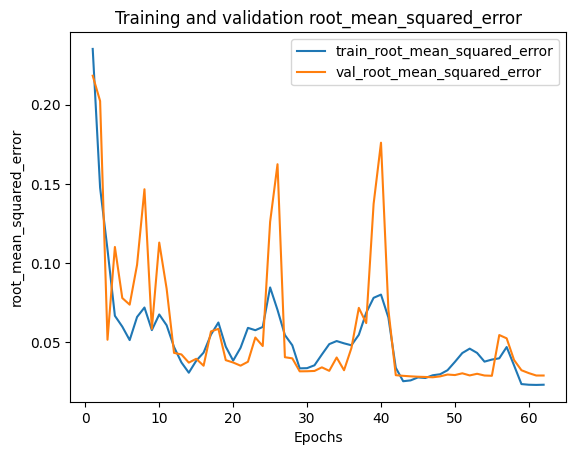

In [ ]:
log = model.fit(
    xTrain,
    yTrain,
    epochs=100,
    batch_size=128,
    validation_split = 0.25,
    verbose=1,
    callbacks=[earlyStopping],
    shuffle=False)
plot_metric(log, 'root_mean_squared_error')

In [ ]:
n_steps = 20

xTest = []
yTest = []

for i in range(n_steps, len(testDataScaled)):
    xTest.append(testDataScaled[i-n_steps:i, 0])
    yTest.append(testDataScaled[i, 0])

xTest, yTest = np.array(xTest), np.array(yTest)
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))


In [ ]:
predictions = model.predict(xTest)
output = sc.inverse_transform(predictions)
rmse = np.sqrt(mean_squared_error(predictions, yTest)) #Calculating of RMSE
rmse

25/25 [==============================] - 4s 91ms/step


0.04095234024276344

In [ ]:
eval = model.evaluate(xTest, yTest) #Calculating of additional metrics (Loss, RMSE, MAE)

25/25 [==============================] - 2s 66ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - mean_absolute_error: 0.0315


In [ ]:
df1 = pd.DataFrame(testingData['Adj Close']).astype(float)
df1 = df1.iloc[:-20]
df1 = df1.reset_index(drop=False)

df2 = pd.DataFrame(output, columns = ['Pred Adj Close']).astype(float)


In [ ]:
df = df1.join(df2)
df = df.set_index('Date')
df

,Adj Close,Pred Adj Close
Date,,
2021-01-04,27258.380859,28311.140625
2021-01-05,27158.630859,28220.728516
2021-01-06,27055.939453,28197.853516
2021-01-07,27490.130859,28211.697266
2021-01-08,28139.029297,28266.189453
...,...,...
2024-02-20,38363.609375,38515.054688
2024-02-21,38262.160156,38623.742188
2024-02-22,39098.679688,38786.582031


Results

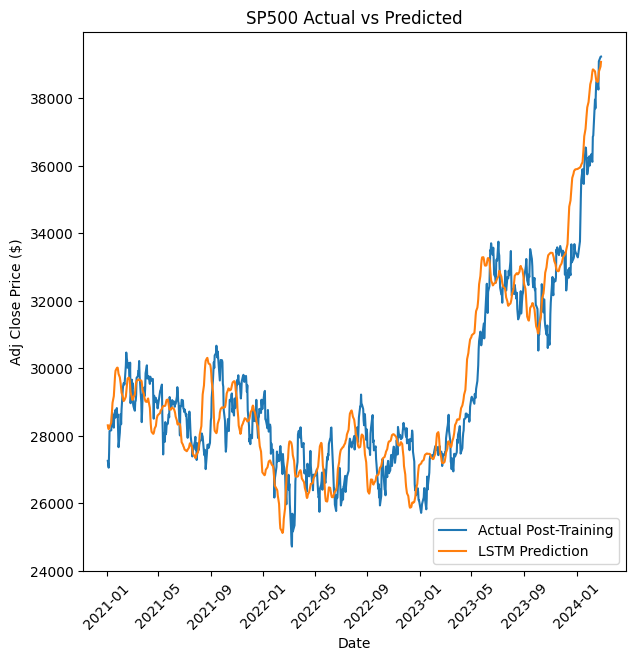

In [ ]:
real = df['Adj Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(7,7))
plt.title('NIkkei Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Post-Training','LSTM Prediction'], loc='lower right')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

last_sequence = testDataScaled[-n_steps:].reshape(1, n_steps, 1)
future_predictions = []
for _ in range(25):
    next_day_pred = model.predict(last_sequence)
    future_predictions.append(next_day_pred.flatten()[0])
    last_sequence = np.append(last_sequence[:, 1:, :], np.expand_dims(next_day_pred, axis=1), axis=1)

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = sc.inverse_transform(future_predictions)

last_date = testingData.index.max()
# Using bdate_range to ensure only business days are included
predicted_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=25, freq='B')

predicted_df = pd.DataFrame(future_predictions, index=predicted_dates, columns=['Predicted Adj Close'])
print(predicted_df)


1/1 [==============================] - 0s 43ms/step
            Predicted Adj Close
2024-03-28         39197.136719
2024-03-29         39235.921875
2024-04-01         39203.679688
2024-04-02         39123.617188
2024-04-03         39020.140625
2024-04-04         38909.281250
2024-04-05         38799.328125
2024-04-08         38694.242188
2024-04-09         38593.882812
2024-04-10         38499.187500
2024-04-11         38408.246094
2024-04-12         38320.683594
2024-04-15         38235.839844
2024-04-16         38153.753906
2024-04-17         38072.691406
2024-04-18         37993.871094
2024-04-19         37916.433594
2024-04-22         37841.460938
2024-04-23         37769.457031
2024-04-24         37699.503906
2024-04-25         37631.054688
2024-04-26         37566.679688
2024-04-29         37503.675781
2024-04-30         37442.261719
2024-05-01         37382.527344


In [ ]:
predicted_df

,Predicted Adj Close
2024-03-28,39197.136719
2024-03-29,39235.921875
2024-04-01,39203.679688
2024-04-02,39123.617188
2024-04-03,39020.140625
2024-04-04,38909.281250
2024-04-05,38799.328125
2024-04-08,38694.242188
2024-04-09,38593.882812
2024-04-10,38499.187500
